## Semantic Segmentation Model

#### Import Libraries

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

import torchvision.transforms.functional as F

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from google.colab import auth
auth.authenticate_user()



#### Define a Helper Function and a Color Map

In [4]:
# Display an array of images side-by-side
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# Define a colour map so we can easily change the mask colour for each class later on   
color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

#### Load the Dataset

In [5]:
import os
# The data has been provided in this repo
DATA_PATH = 'drive/MyDrive/images/CamVid/'

x_train_dir = os.path.join(DATA_PATH, 'train')
y_train_dir = os.path.join(DATA_PATH, 'trainmask')

x_val_dir = os.path.join(DATA_PATH, 'val')
y_val_dir = os.path.join(DATA_PATH, 'valmask')

x_test_dir = os.path.join(DATA_PATH, 'test')
y_test_dir = os.path.join(DATA_PATH, 'testmask')

# Defining utility function
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
!cd drive/MyDrive/im

/bin/bash: line 0: cd: drive/MyDrive/im: No such file or directory


#### Install Segmentation Models for Pytorch

In [7]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=a217360c863f5ed0cfe9f9f02b6abe8f2c8df4c9a891d99162fab924fb9f1407
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=40eca601bbf1eaee4acc5242528b609cae0e59c4f79dfd97e1e40051af22dee9
  Stored in directory: /root/.cache/pip/w

#### Define DataLoader

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import cv2

In [9]:
class CamVidDataset(Dataset):
   
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, # images path
            masks_dir, # masks path
            classes=None, # list of classes we want to extract
            augmentation=None, # data transformations
            preprocessing=None, # shape manipulation and normalization
    ):
        
        # Get the file names
        self.ids = os.listdir(images_dir)
        
        # filepaths for each image and mask
        self.images_paths = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_paths = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # encode string names to corresponding mask value
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read image
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # image read in BGR order so convert back
        
        # read the mask
        mask = cv2.imread(self.masks_paths[i], 0)
        
        # extract the specified classes
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

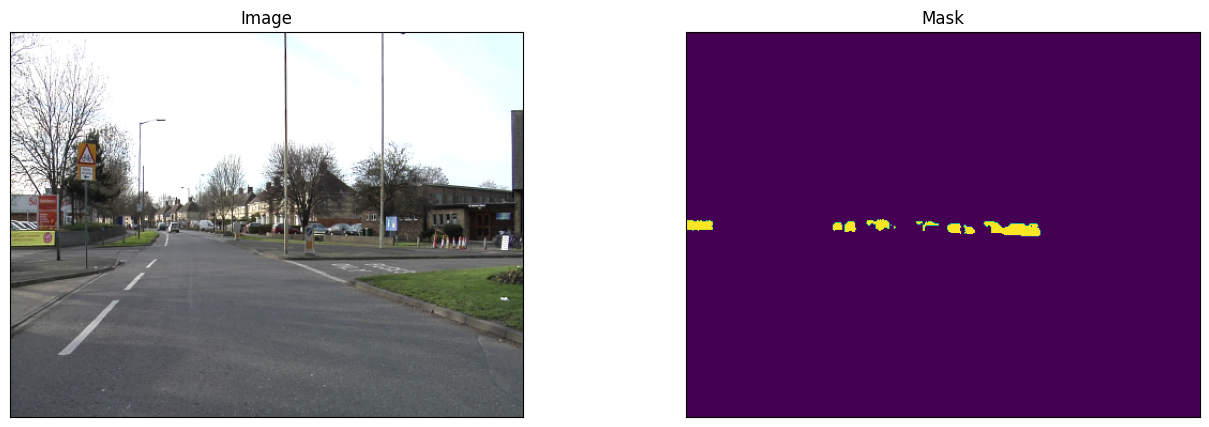

In [10]:
# Visualizing what we have so far with an example of cars
dataset = CamVidDataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[15] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

#### Apply Augmentation / Transfomrations

In [11]:

import albumentations as A

def training_augmentation():
    train_transform = [
        # p in the below is the probability of applying the augmentation
        
        # Pad and crop the image to 320x320
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),
        
        # Flip image
        A.HorizontalFlip(p=0.5),

        # Add noise
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.GridDistortion(p=0.8, num_steps=10),

        # Colour manipulations
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=1.0,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=1.0,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    
    # create a pipeline from the transformations defined above
    return A.Compose(train_transform)


def validation_augmentation():
    # For validation, we only apply padding as needed
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def preprocessing(preprocessing_fn):
    # The smp library provides the preprocessing function based on the selected backbone
    # This will be used for preprocessing
    
    _transform = [
        # preprocess the images
        A.Lambda(image=preprocessing_fn),
        
        # convert to tensores
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

#### Define the Model

In [12]:
ENCODER = 'resnet50' # use resnet50 similar to the PyTorch deeplabv3_resnet50 example above
ENCODER_WEIGHTS = 'imagenet' # resnet models were trained on imagenet
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
ACTIVATION = 'softmax2d' # for mutliclass segmentation use 'softmax2d'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create baseline segmentation model
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# the smp library provides the appropriate pre-processing pipeline based on the selected parameters
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 301MB/s]


#### Define the DataLoaders

In [13]:
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=training_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = CamVidDataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=validation_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

#### Get the Training Parameters

In [14]:
NEPOCHS = 50 # train using only 40 epochs in the interest of time for this tutorial

loss = smp.utils.losses.DiceLoss() # This is the same as F1 Score

metrics = [
    smp.utils.metrics.IoU(threshold=0.5), # Use IoU as explained above
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
# Use smp utility functions to run each training and validation epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#### Train the Model

In [17]:
max_iou = 0

for i in range(0, NEPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # Save best model
    if max_iou < valid_logs['iou_score']:
        max_iou = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    # Reduce the learning rate after on epoch 25
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5


Epoch: 0
train:  11%|█         | 5/46 [00:05<00:44,  1.08s/it, dice_loss - 0.1092, iou_score - 0.819]


KeyboardInterrupt: ignored

#### Evaluate the Best Model

In [18]:
best_model = torch.load('./best_model.pth')

test_dataset = CamVidDataset(
    x_test_dir,
    y_test_dir,
    augmentation = validation_augmentation(),
    preprocessing = preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [19]:
test_epoch = smp.utils.train.ValidEpoch(
    model = best_model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s, dice_loss - 0.1433, iou_score - 0.7649]


#### Best Model For Prediction

In [20]:
# Load the test dataset without transformations for comparison purposes
test_dataset_no_transform = CamVidDataset(
    x_test_dir , y_test_dir,
    classes = CLASSES,
)

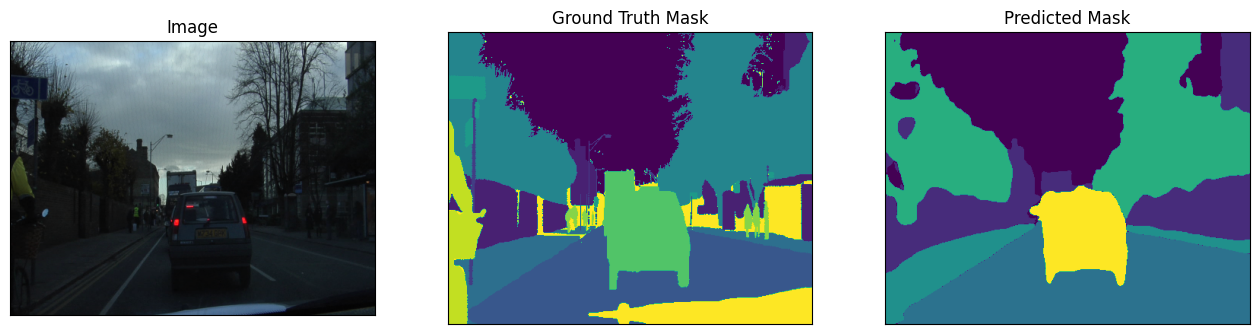

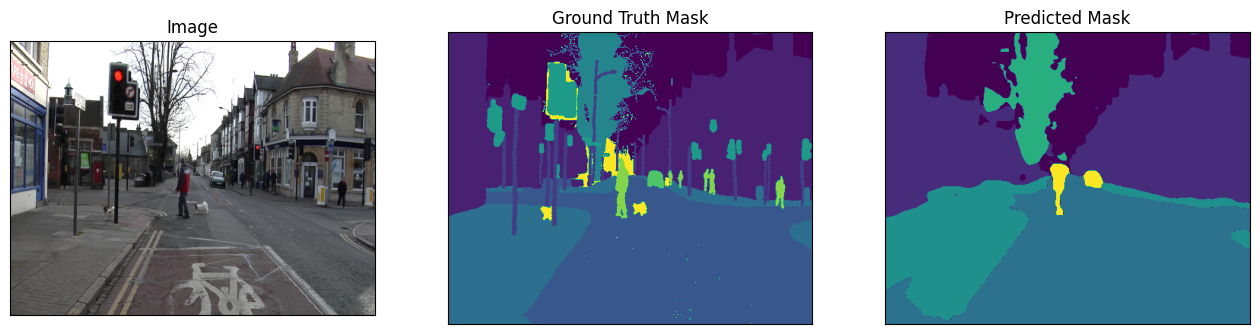

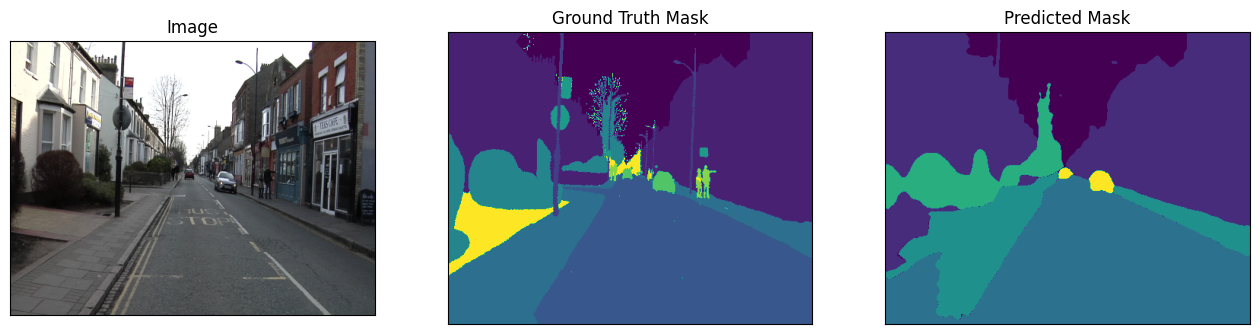

In [21]:
for i in [1,73,108]:
    image_no_transform = test_dataset_no_transform[i][0].astype('uint8')
    image, ground_truth_mask = test_dataset[i]
    ground_truth_mask = ground_truth_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    

    predicted_mask = best_model.predict(x_tensor)
    predicted_mask = (predicted_mask.squeeze().cpu().numpy().round())

    for i, mask in enumerate(ground_truth_mask):
      ground_truth_mask[i] = mask * i * 255 / 12

    for i, mask in enumerate(predicted_mask):
      predicted_mask[i] = mask * i * 255 / 12   

    visualize(
        image = image_no_transform,
        ground_truth_mask=np.stack(ground_truth_mask, axis = -1).sum(axis=2), 
        predicted_mask=np.stack(predicted_mask, axis = -1).sum(axis=2)
    )